# Group 8 Final Project
## Part 2: SVM-Based Person Detector

In [10]:
!pip install statistics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
import pandas as pd
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from numpy import genfromtxt
import csv
from statistics import mean 
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading frame images

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [129, 129, 129, ..., 170, 173, 173],
       [128, 128, 128, ..., 160, 164, 167],
       [131, 131, 130, ..., 146, 147, 147]], dtype=uint8)

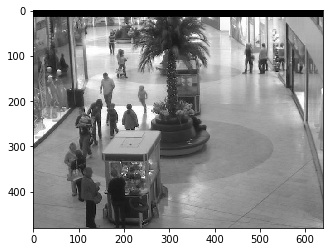

In [11]:
def read_image(number, display=False):
    path = './drive/MyDrive/frames/seq_{}.jpg'.format(str(number).zfill(6))
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if display:
        plt.imshow(img, cmap='gray')
    return img
        
read_image(22, display=True)

In [12]:
frames = []
for i in range(1, 2001):
    frames.append(read_image(i))

In [13]:
print(len(frames))

2000


## Reading people boxes (positives) from frames and analysis on distribution

In [16]:
people_boxes = genfromtxt('./people_rectangles.csv', dtype=int, delimiter=',', skip_header=1)

In [17]:
list_people_boxes = []
for b in people_boxes:
    idx, x, y, w, h = b
    img = frames[idx-1]
    cropped_img = img[y:y+h,x:x+w]
    list_people_boxes.append(cropped_img)

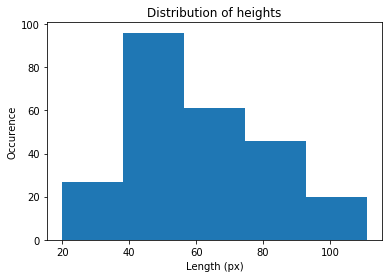

60.692


In [18]:
height = [list_people_boxes[i].shape[0] for i in range(0, 250)]
plt.hist(height, bins=5) 
plt.title("Distribution of heights")
plt.xlabel("Length (px)")
plt.ylabel("Occurence")
plt.show()
print(mean(height))

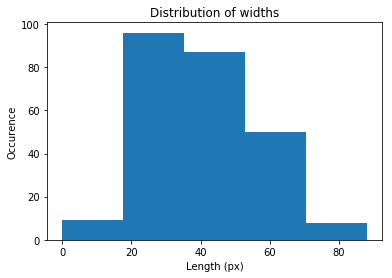

40.2


In [19]:
width = [list_people_boxes[i].shape[1] for i in range(0, 250)]
plt.hist(width, bins=5) 
plt.title("Distribution of widths")
plt.xlabel("Length (px)")
plt.ylabel("Occurence")
plt.show()
print(mean(width))

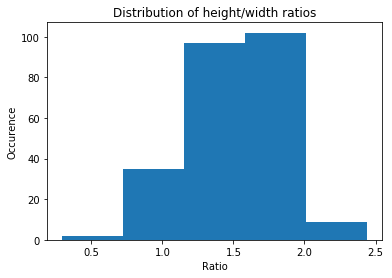

1.5213530239


In [20]:
# Shape distribution
# Maping 100 height to width ratio
ratios = [(float) (list_people_boxes[i].shape[0])/(list_people_boxes[i].shape[1]) for i in range(0, 250) if (list_people_boxes[i].shape[1]) != 0]
plt.hist(ratios, bins=5) 
plt.title("Distribution of height/width ratios")
plt.xlabel("Ratio")
plt.ylabel("Occurence")
plt.show()
print(mean(ratios))

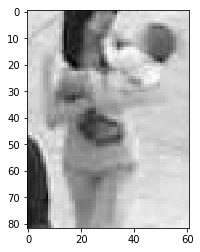

In [21]:
plt.imshow(list_people_boxes[3], cmap='gray')

## Resize people boxes

In [22]:
resized_imgs = []
dim = (40, 60)
resized_img = cv2.resize(list_people_boxes[1], dim, interpolation = cv2.INTER_AREA)
for l in list_people_boxes:
    if l.any():
        resized_img = cv2.resize(l, dim, interpolation = cv2.INTER_AREA)
        resized_imgs.append(resized_img)

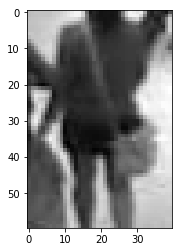

In [23]:
plt.imshow(resized_imgs[50], cmap='gray')

## Creating non-people (negative) boxes from frames

In [24]:
def create_negatives():
    negatives=[]
    for n in range(0, 2000):
        for y in range(0, frames[n].shape[0]-20,60):
            for x in range(0, frames[n].shape[1]-20,40):
                for box in people_boxes:
                    if(box[0] < n):
                        continue
                    if((box[0] == n) and (x >= box[1] - 39) and (x <= box[1] + box[3]) and (y >= box[2] - 59) and (y <= box[2] + box[4])):
                        break
                    elif (box[0] == n+1):
                        negatives.append([n+1,x,y,40,60])
                        break;
                    if(n > 0 and n % 100 == 0):
                        print(str(n) + 'th frame')

    with open('negative_rectangles.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['image_id', 'x', 'y', 'w', 'h'])
        writer.writerows(negatives)

In [25]:
create_negatives()

Streaming output truncated to the last 5000 lines.
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame
1600th frame


In [26]:
non_people_boxes = genfromtxt('./negative_rectangles.csv', dtype=int, delimiter=',', skip_header=1)

In [27]:
negative_boxes = []
for b in non_people_boxes:
    idx, x, y, w, h = b
    img = frames[idx-1]
    cropped_img = img[y:y+h,x:x+w]
    negative_boxes.append(cropped_img)
len(negative_boxes)

156430

## Generating training set and test set

In [28]:
negative_boxes = negative_boxes[-30000:]

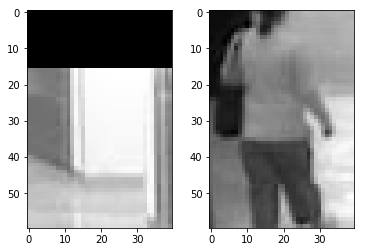

In [29]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(negative_boxes[503], cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(resized_imgs[0], cmap='gray')
plt.show()

In [30]:
negative = np.asarray(negative_boxes)
positive = np.asarray(resized_imgs)
print(negative.shape)
print(positive.shape)

(30000, 60, 40)
(35841, 60, 40)


In [31]:
# Removing NaNs although there shouldn't be any
negative = np.nan_to_num(negative)
positive = np.nan_to_num(positive)
print(negative.shape)
print(positive.shape)

(30000, 60, 40)
(35841, 60, 40)


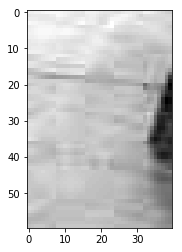

In [32]:
plt.imshow(negative[3349], cmap='gray')

In [33]:
# Generating labels
negative_labels = np.full((negative.shape[0],), 0)
positive_labels = np.full((positive.shape[0],), 1)

In [34]:
data = np.vstack((negative, positive))
labels = np.concatenate((negative_labels, positive_labels), axis=None)

In [35]:
print(data.shape)
print(labels.shape)

(65841, 60, 40)
(65841,)


In [36]:
from sklearn.model_selection import train_test_split

# Split test and training set
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.17, test_size=0.02)

In [37]:
X_train.shape

(11192, 60, 40)

## Features preprocessing (HoG features)

In [40]:
hog_image, h = hog(resized_imgs[67], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=True)

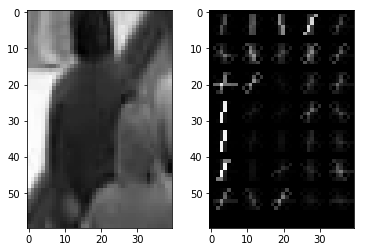

In [41]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(resized_imgs[67], cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(h, cmap='gray')
plt.show()

In [42]:
from skimage import feature

def preprocess(X_train):
    h_train = [feature.hog(img, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2)) 
               for img in X_train]
    return np.asarray(h_train)
    
preprocessed_train = preprocess(X_train)

In [43]:
preprocessed_train.shape

(11192, 864)

## Generate SVM classifier, and measure accuracy

In [44]:
clf = svm.SVC(C=100)
clf.fit(preprocessed_train, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [45]:
import pickle
s = pickle.dumps(clf)

In [46]:
p_test = preprocess(X_test)

In [47]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(p_test)
accuracy_score(y_test, y_pred)

0.9749430523917996

## Sliding window approach to count number of detection in a frame

In [48]:
def predict_nb_detections(frame, clf):
    boxes, confidences = [], []
    h, w = frame.shape
    classes = clf.classes_
    score_thresh = 1.0
    iou_thresh = 0.1
    x, y = 0, 0
    while x <= (w-40):
        y=0
        while y <= (h-60):
            box = frame[y:y+60, x:x+40]
            hog = feature.hog(box, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2))
            confidence_score = clf.decision_function([hog])
            # It's a person! (in other words, it's classes[1] == 1)
            if confidence_score[0] > 0:
                boxes.append([x, y, 40, 60])
                confidences.append(abs(confidence_score[0]))
            y += 20
        x+= 10
                
    # Non-max suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_thresh, iou_thresh)
    return len(idxs)

## Count number detections for 2000 frames

In [ ]:
preds = []
for i in range(1, 2001):
    pred = predict_nb_detections(frames[i-1], clf)
    preds.append([i, pred])
    if (i % 100 == 0): print(str(i)+'th frame')

    
with open('final_results.csv', 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'count'])
    writer.writerows(preds)

## Calculate accuracy using YOLO results as ground truth

In [ ]:
yolo_results = genfromtxt('./yolov3_results.csv', dtype=int, delimiter=',', skip_header=1)
results = genfromtxt('./final_results.csv', dtype=int, delimiter=',', skip_header=1)

In [ ]:
# remove ID
yolo_results = yolo_results[:,1:]
results = results[:,1:]

In [ ]:
print(str(accuracy_score(yolo_results, results)*100)+"%")

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [129, 129, 129, ..., 170, 173, 173],
       [128, 128, 128, ..., 160, 164, 167],
       [131, 131, 130, ..., 146, 147, 147]], dtype=uint8)

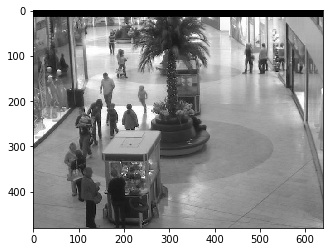

In [54]:
def read_image_colour(number, display=False):
    path = './drive/MyDrive/frames/seq_{}.jpg'.format(str(number).zfill(6))
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if display:
        plt.imshow(img, cmap='gray')
    return img
        
read_image(22, display=True)

In [55]:
def print_rectangles(nb, clf):
    frame_colour = read_image_colour(nb)
    frame = read_image(nb)
    boxes, confidences = [], []
    h, w = frame.shape
    print(frame.shape)
    classes = clf.classes_
    score_thresh = 1.0
    iou_thresh = 0.1
    x, y = 0, 0
    while x <= (w-40):
        y = 0
        while y <= (h-60):
            box = frame[y:y+60, x:x+40]
            hog = feature.hog(box, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2))
            confidence_score = clf.decision_function([hog])
            # It's a person! (in other words, it's classes[1] == 1)
            if confidence_score[0] > 0:
                boxes.append([x, y, 40, 60])
                confidences.append(abs(confidence_score[0]))
            y += 20
        x+= 10
        
    # Non-max suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_thresh, iou_thresh)
    
    # Ensure at least one detection exists
    if len(idxs) > 0:
        # Iterate over corrected detected persons
        for idx in idxs.flatten():
            # Draw detection box
            x, y = boxes[idx][0], boxes[idx][1]
            w, h = boxes[idx][2], boxes[idx][3]
            cv2.rectangle(frame_colour, (x, y), (x + w, y + h), color=(255,0,0), thickness=1)
    
    final_img = frame_colour.copy()
    
    big = cv2.resize(final_img, dsize=(0,0), fx=5, fy=5)
    # Output resulting image
    plt.figure(figsize=(15,15))
    plt.imshow(big)

(480, 640)


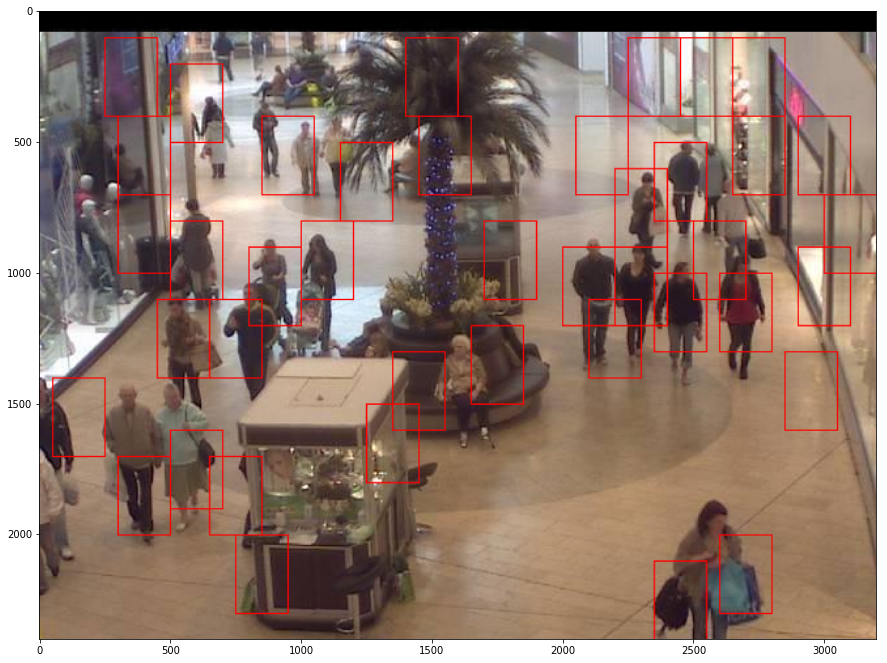

In [56]:
print_rectangles(250, clf)

## IoU calculation

In [262]:
def get_boxes(frame, clf):
    boxes, confidences = [], []
    h, w = frame.shape
    classes = clf.classes_
    score_thresh = 1.0
    iou_thresh = 0.1
    x, y = 0, 0
    while x <= (w-40):
        y = 0
        while y <= (h-60):
            box = frame[y:y+60, x:x+40]
            hogF = hog(box, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2))
            confidence_score = clf.decision_function([hogF])
            # It's a person! (in other words, it's classes[1] == 1)
            if confidence_score[0] > 0:
                boxes.append([x, y, 40, 60])
                confidences.append(abs(confidence_score[0]))
            y += 20
        x+= 10
        
    # Non-max suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_thresh, iou_thresh)
    
    # Ensure at least one detection exists
    if len(idxs) > 0:
        result = []
        # Iterate over corrected detected persons
        for idx in idxs.flatten():

            # Draw detection box
            x, y = boxes[idx][0], boxes[idx][1]
            w, h = boxes[idx][2], boxes[idx][3]
            result.append([x,y,w,h])
    
    return np.asarray(result)

In [243]:
yolo_people = genfromtxt('./people_rectangles.csv', dtype=int, delimiter=',', skip_header=1)

In [316]:
def calculate_iou(idx, people_boxes):
    frame = [[0]*640]*480
    # calculate true positives
    boxes = yolo_people[np.where(yolo_people[:,0] == idx)]
    tp = 0
    for b in boxes:
        for x in range(b[1], (b[1]+b[3])):
            for y in range(b[2], (b[2]+b[4])):
                # False negative
                if(x > 479) or (y > 639):
                    continue
                frame[y][x] = 1
    
    for p in people_boxes:
        for x in range(p[0], (p[0]+p[2])):
            for y in range(p[1], (p[1]+p[3])): 
                if(x > 479) or (y > 639):
                    continue
                if frame[y][x] == 1 or frame[y][x] == 2:
                    # True positive
                    frame[y][x] = 2
                else:
                    # False positive
                    frame[y][x] = 3

    tp, fp, tn, fn = 0.0, 0.0, 0.0, 0.0
    for i in range(480):
        for j in range(640):
            if frame[i][j] == 0:
                tn+=1
            elif frame[i][j] == 1:
                fn+=1
            elif frame[i][j] == 2:
                tp+=1
            elif frame[i][j] == 3:
                fp+=1
                
    denom = (tp+fp+fn)    
    iou = tp / float(denom)
    
    return iou

In [317]:
acc = 0
for i in range(2000):
    boxes = get_boxes(frames[i], clf)
    iou = calculate_iou(i+1, boxes)
    acc += iou
    
avg_iou = acc/100
print(avg_iou)

0.631576129898
